# Import

In [1]:
import sys

root_dir = '../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pandas as pd

pd.set_option('display.max_columns', 100)

from modules import losses, models, samplers, searches, regularizers, evaluators, trainers, datasets, distributions

# Dataset

In [2]:
dataset = datasets.ML100k()
n_user = dataset.n_user
n_item = dataset.n_item
train_set, test_set = dataset.get_train_and_test_set(neg_pair_weight=10)

# device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

# Evaluator

In [3]:
# k
ks = [5, 10, 50]

score_function_dict = {
    "Recall"      : evaluators.recall,
    "Unpopularity": evaluators.unpopularity,
    "Unpopularity2": evaluators.unpopularity2,
    "Unpopularity3": evaluators.unpopularity3,
    "F1-score"    : evaluators.f1_score,
    "F1-score2"    : evaluators.f1_score2,
    "F1-score3"    : evaluators.f1_score3
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)
# coverage = evaluators.CoverageEvaluator(test_set, ks)
# hubness = evaluators.HubnessEvaluator(test_set, ks)

# Sampler

In [4]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [5]:
# Hyperparameters
lr = 1e-3
n_dim = 10
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# No Training Result

In [6]:
knn = searches.NearestNeighborhood(model)
trainer.valid(knn, userwise)
re_no_training = trainer.valid_scores.copy()
display(re_no_training)

,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.065152,0.969564,6.622632,0.061691,0.099606,0.123684,0.031369,0.127685,0.970179,6.657061,0.123793,0.18712,0.240427,0.091586,0.520492,0.917757,6.310019,0.524421,0.574732,0.916322,0.513364


# Training

In [7]:
# only traing no validation
trainer.fit(n_batch, n_epoch)

# Result

## Base CML

In [8]:
knn = searches.NearestNeighborhood(model)

# Recall
trainer.valid(knn, userwise)
re_base = trainer.valid_scores.copy()
display(re_base)

,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.399656,0.877457,3.327816,0.014431,0.491743,0.683325,0.025265,0.570743,0.891249,3.640809,0.049686,0.649663,0.96318,0.08215,0.887389,0.88814,4.769724,0.438394,0.871655,1.486692,0.513118


## CML+MP

In [9]:
n_sample = 30
bias_li = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma = distributions.Gamma()

In [10]:
re_mpcml_li = []
for bias in bias_li:
    print(f'bias={bias}')
    mp = searches.NoDistinctionMutualProximity(model, gamma, n_sample, bias)
    trainer.valid(mp, userwise)
    re = trainer.valid_scores.copy()
    display(re)
    re_mpcml_li.append(re)

bias=0.0


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.346127,0.919135,4.011491,0.026527,0.439617,0.605595,0.044512,0.520646,0.922111,4.184822,0.066272,0.608238,0.896295,0.108414,0.874018,0.893911,4.946922,0.450206,0.863741,1.473604,0.52988


bias=0.1


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.366774,0.911523,3.856205,0.023289,0.461843,0.638792,0.040399,0.532438,0.917285,4.091195,0.063238,0.618707,0.91359,0.103939,0.877647,0.893098,4.924572,0.448377,0.866268,1.478257,0.527261


bias=0.2


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.369951,0.907176,3.781052,0.021955,0.464349,0.642793,0.037424,0.541669,0.913248,4.01513,0.060981,0.626695,0.926769,0.100207,0.880739,0.892433,4.903636,0.447037,0.867928,1.481924,0.525611


bias=0.3


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.370082,0.903625,3.716687,0.020638,0.46482,0.642495,0.035794,0.549699,0.910486,3.958164,0.058786,0.633161,0.937769,0.097023,0.880396,0.891709,4.884873,0.445696,0.867682,1.480809,0.523681


bias=0.4


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.375762,0.899931,3.655339,0.01959,0.46992,0.650768,0.033387,0.556069,0.907318,3.900786,0.057141,0.638526,0.946511,0.094261,0.882521,0.891215,4.866433,0.444852,0.869051,1.483291,0.522167


bias=0.5


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.382823,0.897528,3.61957,0.018584,0.476478,0.661171,0.0323,0.557747,0.904678,3.85477,0.055208,0.639363,0.94773,0.091304,0.882792,0.89067,4.850814,0.443801,0.869169,1.483055,0.520605


bias=0.6


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.388623,0.894759,3.572776,0.017894,0.480001,0.668588,0.030885,0.560312,0.902792,3.820063,0.054192,0.641119,0.95068,0.089581,0.885268,0.889997,4.828841,0.442335,0.870596,1.485874,0.518818


bias=0.7


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.38981,0.891516,3.526088,0.017062,0.482237,0.670461,0.029712,0.563747,0.899898,3.774181,0.052857,0.644206,0.955104,0.08745,0.885695,0.889521,4.813929,0.441286,0.870845,1.485963,0.517353


bias=0.8


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.392407,0.888167,3.47452,0.015924,0.48449,0.673428,0.027887,0.568193,0.897691,3.736697,0.051748,0.647158,0.960673,0.085592,0.886663,0.889063,4.79892,0.440415,0.871409,1.486812,0.515958


bias=0.9


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.395049,0.883987,3.417564,0.015551,0.486765,0.676863,0.027088,0.570262,0.89505,3.695145,0.050648,0.649403,0.96339,0.083805,0.887523,0.888537,4.782538,0.439384,0.871812,1.487414,0.514524


bias=1.0


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.399656,0.877457,3.327816,0.014431,0.491743,0.683325,0.025265,0.570743,0.891249,3.640809,0.049686,0.649663,0.96318,0.08215,0.887389,0.88814,4.769724,0.438394,0.871655,1.486692,0.513118


In [11]:
re_recall = []
re_unpop1 = []
re_unpop2 = []
re_unpop3 = []
for re in re_mpcml_li:
    re_recall.append(re.iloc[-1, 7])
    re_unpop1.append(re.iloc[-1, 8])
    re_unpop2.append(re.iloc[-1, 9])
    re_unpop3.append(re.iloc[-1, 10])

## Recall vs Unpopularity1

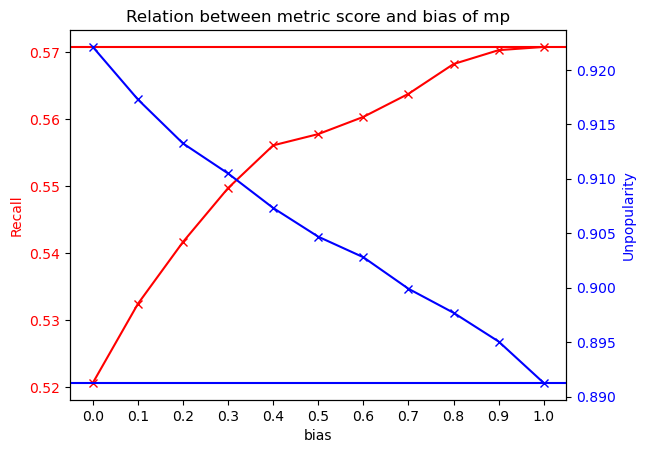

In [12]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop1, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
# Base CML
ax1.axhline(re_base.iloc[-1, 7], color='red', linestyle='-')
ax2.axhline(re_base.iloc[-1, 8], color='blue', linestyle='-')
# No training
# ax1.axhline(re_no_training.iloc[-1, 7], color='red', linestyle='--')
# ax2.axhline(re_no_training.iloc[-1, 8], color='blue', linestyle='--')

# グラフの表示
plt.show()

## Recall vs Unpopularity2

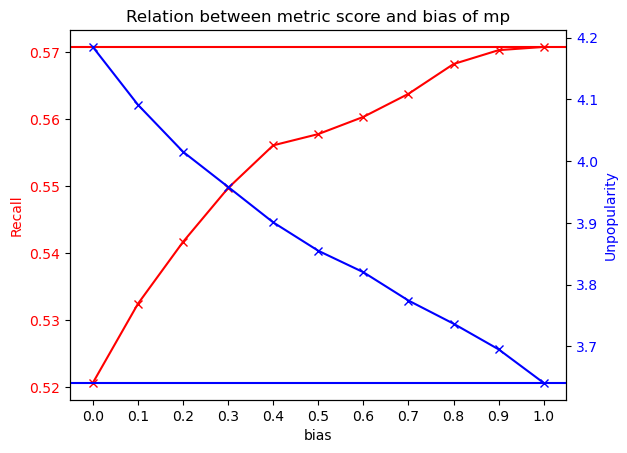

In [13]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop2, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
# Base CML
ax1.axhline(re_base.iloc[-1, 7], color='red', linestyle='-')
ax2.axhline(re_base.iloc[-1, 9], color='blue', linestyle='-')
# No training
# ax1.axhline(re_no_training.iloc[-1, 7], color='red', linestyle='--')
# ax2.axhline(re_no_training.iloc[-1, 9], color='blue', linestyle='--')

# グラフの表示
plt.show()

## Recall vs Unpopularity3

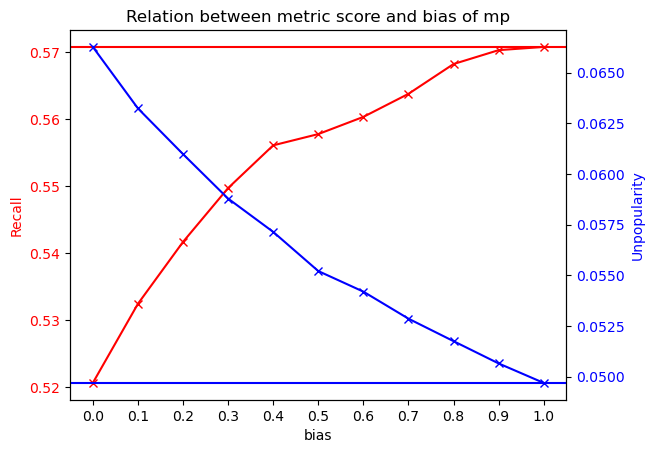

In [14]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop3, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
# Base CML
ax1.axhline(re_base.iloc[-1, 7], color='red', linestyle='-')
ax2.axhline(re_base.iloc[-1, 10], color='blue', linestyle='-')
# No training
# ax1.axhline(re_no_training.iloc[-1, 7], color='red', linestyle='--')
# ax2.axhline(re_no_training.iloc[-1, 10], color='blue', linestyle='--')

# グラフの表示
plt.show()